## Modules

In [89]:
from warnings import filterwarnings
#Data wrangling
import pandas as pd
import plotly.express as px
import numpy as np
import datetime

# Data visualization
import cufflinks as cf
import matplotlib.pyplot as plt

# Modeling
from keras import metrics
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from varclushi import VarClusHi
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Environment setupt
cf.set_config_file(theme="white", offline=True)
filterwarnings("ignore")

In [2]:
def checkDates(data):
    data["Date"]=data["date_rptd"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))
    date_index = pd.date_range(start=data["Date"].min(), end=data["Date"].max(), freq="D")
    data = data.set_index("Date").reindex(date_index)
    data.drop(columns=["date_rptd"], inplace=True)
    data.rename(columns={'0': "Crimes"}, inplace= True)
    data["Crimes"]= data["Crimes"].fillna(0)
    return data

## Load data

In [3]:
data= pd.read_csv("CrimenesTipo103Zona1.csv")

In [4]:
data= checkDates(data)

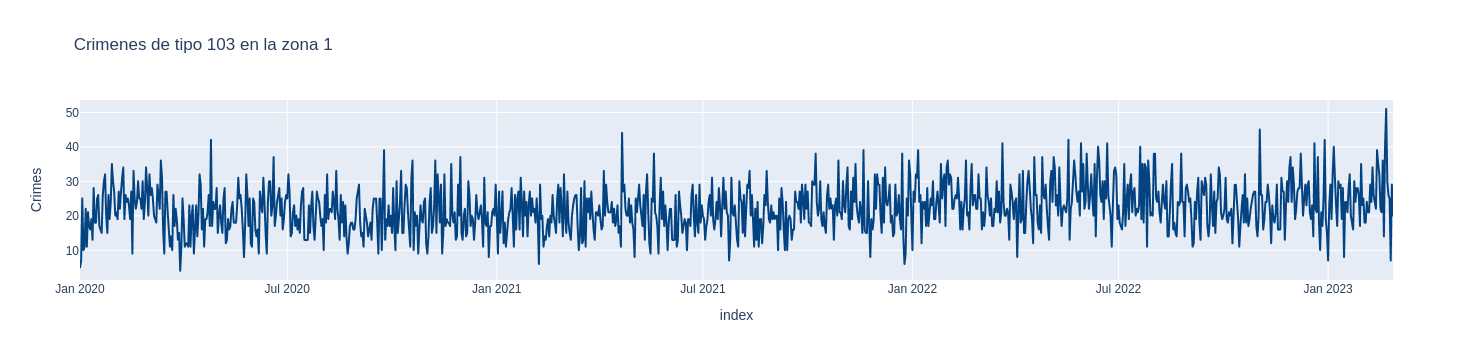

In [5]:
fig = px.line(data, x=data.index, y="Crimes",title=f"Crimenes de tipo 103 en la zona 1")
fig.update_traces(line_color='#044382')
fig.show()

## Feature engineering

In [21]:
df= data.copy()

In [84]:
df.y

2020-01-01     7.0
2020-01-02    25.0
2020-01-03    10.0
2020-01-04    11.0
2020-01-05    22.0
              ... 
2023-02-23    25.0
2023-02-24     7.0
2023-02-25    29.0
2023-02-26    20.0
2023-02-27     NaN
Freq: D, Name: y, Length: 1154, dtype: float64

### Smooting variiables

In [22]:
df["ExponSmoot"] = ExponentialSmoothing(df["Crimes"],trend="add").fit().fittedvalues

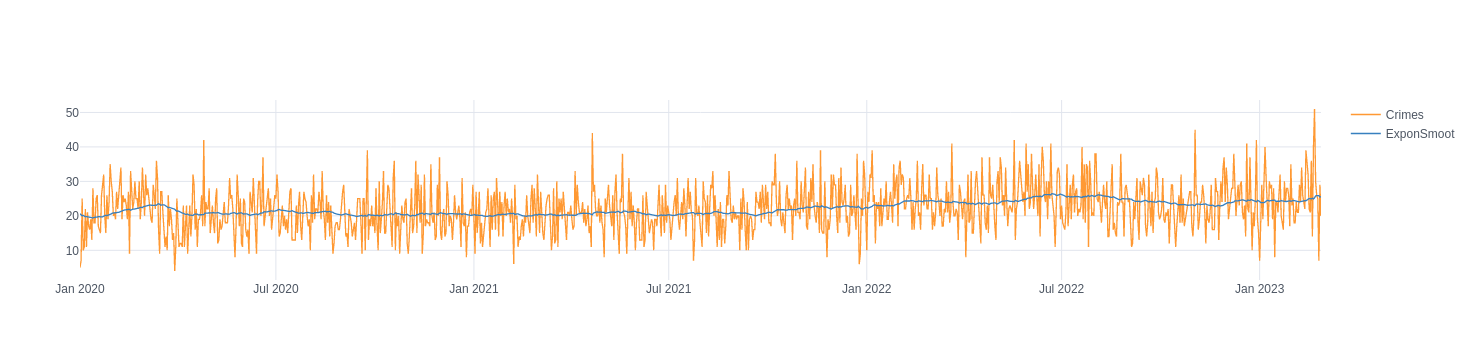

In [23]:
df.iplot()

### New variables

In [24]:
ls_features= [x for x in df.columns]
for i in range(1, 91):
    for feature in ls_features:
        df[f"{feature}(t-{i})"] = df[feature].shift(i)
        df[f"{feature}_diff_{i}"] = df[feature].diff(i)
        df[f"{feature}_pct_{i}"] = df[feature].pct_change(i)
        df[f"{feature}_ma_{i+1}"] = df[feature].rolling(i+1).mean()
        df[f"{feature}_max_{i+1}"] = df[feature].rolling(i+1).max()
        df[f"{feature}_min_{i+1}"] = df[feature].rolling(i+1).min()
        df[f"{feature}_std_{i+1}"] = df[feature].rolling(i+1).std()
        df[f"{feature}_median_{i+1}"] = df[feature].rolling(i+1).median()

### Create target

In [26]:
df["y"]= df["Crimes"].shift(-1)

In [79]:
df.isna().mean()

Crimes                  0.000000
ExponSmoot              0.000000
Crimes(t-1)             0.000867
Crimes_diff_1           0.000867
Crimes_pct_1            0.000867
                          ...   
ExponSmoot_std_91       0.077990
ExponSmoot_median_91    0.077990
y                       0.000867
y_hat                   0.000000
y_hat_W                 0.000000
Length: 1443, dtype: float64

## EDA

In [27]:
ls_cont = [x for x in df.columns if x != "y"]

### Outliers

Pendiente, porque realmente es valioso esos casos

### Missings

In [28]:
ls_missing = [x for x, y in df.isna().mean().items() if y > 0.3]

### Unary variables

In [29]:
ls_unary = [x for x, y in df.nunique().items() if y == 1]

### Correlated variables

In [30]:
corr_matrix = df[[x for x in ls_cont if x not in ls_unary+ls_missing]].dropna().corr()

In [31]:
corr_matrix

,Crimes,ExponSmoot,Crimes(t-1),Crimes_diff_1,Crimes_pct_1,Crimes_ma_2,Crimes_max_2,Crimes_min_2,Crimes_std_2,Crimes_median_2,...,Crimes_std_91,Crimes_median_91,ExponSmoot(t-90),ExponSmoot_diff_90,ExponSmoot_pct_90,ExponSmoot_ma_91,ExponSmoot_max_91,ExponSmoot_min_91,ExponSmoot_std_91,ExponSmoot_median_91
Crimes,1.000000,0.255283,0.141133,0.654790,0.573381,0.755018,0.701287,0.629290,0.191791,0.755018,...,0.177021,0.253174,0.225414,0.061428,0.058140,0.239156,0.228394,0.249903,0.042128,0.236208
ExponSmoot,0.255283,1.000000,0.327124,-0.055081,-0.060173,0.385546,0.342699,0.339511,0.062657,0.385546,...,0.603858,0.926549,0.782572,0.389218,0.393971,0.921441,0.896507,0.914199,0.343538,0.913430
Crimes(t-1),0.141133,0.327124,1.000000,-0.655833,-0.620759,0.755699,0.663900,0.674683,0.104916,0.755699,...,0.174158,0.257619,0.230966,0.164361,0.165445,0.241165,0.235276,0.254439,0.040314,0.237197
Crimes_diff_1,0.654790,-0.055081,-0.655833,1.000000,0.911145,-0.001211,0.027902,-0.035231,0.066150,-0.001211,...,0.002024,-0.003625,-0.004445,-0.078640,-0.081976,-0.001752,-0.005463,-0.003691,0.001347,-0.000971
Crimes_pct_1,0.573381,-0.060173,-0.620759,0.911145,1.000000,-0.031834,0.110980,-0.192240,0.313707,-0.031834,...,0.013514,-0.017852,-0.019917,-0.063626,-0.068034,-0.013616,-0.015354,-0.018445,-0.000345,-0.011829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ExponSmoot_ma_91,0.239156,0.921441,0.241165,-0.001752,-0.013616,0.317943,0.279068,0.284155,0.043562,0.317943,...,0.615386,0.920163,0.897023,0.098334,0.106619,1.000000,0.974481,0.977383,0.423393,0.996719
ExponSmoot_max_91,0.228394,0.896507,0.235276,-0.005463,-0.015354,0.306923,0.271315,0.272044,0.046447,0.306923,...,0.651294,0.900242,0.889281,0.071215,0.081356,0.974481,1.000000,0.924839,0.588344,0.963022
ExponSmoot_min_91,0.249903,0.914199,0.254439,-0.003691,-0.018445,0.333845,0.288621,0.303560,0.035657,0.333845,...,0.578849,0.879562,0.916742,0.057955,0.061288,0.977383,0.924839,1.000000,0.251960,0.971417
ExponSmoot_std_91,0.042128,0.343538,0.040314,0.001347,-0.000345,0.054571,0.058327,0.036477,0.031353,0.054571,...,0.418324,0.443241,0.333060,0.038695,0.054478,0.423393,0.588344,0.251960,1.000000,0.405855


In [32]:
ls_checked = []
ls_correlated = []
for i, col in enumerate(corr_matrix.columns):
    ls_checked.append(col)
    ls_correlated += corr_matrix[(corr_matrix[col] == 1) & (~corr_matrix.index.isin(ls_checked))].index.tolist()
ls_correlated = list(set(ls_correlated))

In [33]:
ls_correlated

['Crimes_median_2', 'ExponSmoot_median_2']

### Remove variables

In [34]:
df = df.drop(columns=ls_unary+ls_missing+ls_correlated)
ls_cont = [x for x in ls_cont if x in df.columns]

## Preprossesing

In [35]:
X= df[ls_cont].copy()

### Imputer

In [36]:
im = SimpleImputer(strategy="median")
Xi = pd.DataFrame(data=im.fit_transform(X), columns=X.columns, index=X.index)

### Scaler

In [37]:
sc = MinMaxScaler()
Xs = pd.DataFrame(data=sc.fit_transform(Xi), columns=Xi.columns, index=Xi.index)

### Multicolineality

In [38]:
vc = VarClusHi(df=Xs, feat_list=Xs.columns, maxclus=10)
vc.varclus()

In [39]:
vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
243,0,ExponSmoot_ma_75,0.998705,0.856342,0.009016
237,0,ExponSmoot_ma_74,0.998718,0.858323,0.009046
231,0,ExponSmoot_ma_73,0.998696,0.860293,0.009333
249,0,ExponSmoot_ma_76,0.998597,0.854510,0.009647
225,0,ExponSmoot_ma_72,0.998620,0.862302,0.010021
...,...,...,...,...,...
1367,9,Crimes_max_19,0.575589,0.299510,0.605877
1366,9,Crimes_max_18,0.549892,0.293691,0.637267
1365,9,Crimes_max_17,0.525413,0.308980,0.686792
1364,9,Crimes_max_16,0.502648,0.323475,0.735158


In [40]:
res = vc.rsquare.sort_values(by=["Cluster", "RS_Ratio"]).groupby(["Cluster"]).first()

In [41]:
res

,Variable,RS_Own,RS_NC,RS_Ratio
Cluster,,,,
0,ExponSmoot_ma_75,0.998705,0.856342,0.009016
1,Crimes_ma_12,0.819866,0.463270,0.335613
2,Crimes,0.904544,0.087727,0.104636
3,Crimes_std_55,0.896859,0.325534,0.152923
4,ExponSmoot_diff_64,0.906271,0.227277,0.121297
5,ExponSmoot_std_68,0.928307,0.192512,0.088785
6,Crimes_min_66,0.917116,0.184189,0.101597
7,ExponSmoot_max_12,0.983102,0.875096,0.135287
8,ExponSmoot_std_28,0.943059,0.208281,0.071921


In [42]:
bf = [x for x in res["Variable"]]

In [43]:
bf

['ExponSmoot_ma_75',
 'Crimes_ma_12',
 'Crimes',
 'Crimes_std_55',
 'ExponSmoot_diff_64',
 'ExponSmoot_std_68',
 'Crimes_min_66',
 'ExponSmoot_max_12',
 'ExponSmoot_std_28',
 'Crimes_max_59']

In [44]:
Xv = Xi[bf].values

### Train test split

In [45]:
y= df[["y"]]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(Xi, y.interpolate(), test_size=0.3, shuffle=False)

In [47]:
scx= MinMaxScaler()
scy= MinMaxScaler()

In [48]:
X_train= scx.fit_transform(X_train)
y_train= scy.fit_transform(y_train)

In [49]:
X_test= scx.transform(X_test)
y_test= scy.transform(y_test)

In [50]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

## Model

In [65]:
model = Sequential()

In [66]:
model.add(LSTM(10, input_shape=X_train.shape[1:], activation="tanh", use_bias=False))

model.add(Dense(100, activation="sigmoid",use_bias=False))

model.add(Dense(1, use_bias=False))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10)                58000     
                                                                 
 dense_2 (Dense)             (None, 100)               1000      
                                                                 
 dense_3 (Dense)             (None, 1)                 100       
                                                                 
Total params: 59,100
Trainable params: 59,100
Non-trainable params: 0
_________________________________________________________________


### Metrics

In [67]:
kmetrics = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae'),
]   

### Callbacks

In [68]:
early_stopping = EarlyStopping(monitor='val_mae', patience=20)

In [69]:
checkpoint = ModelCheckpoint('models/crimes/model_{val_mae:.3f}.h5',
                             save_best_only=True,
                             save_weights_only=False,
                             monitor='val_mae')

### Setup

In [70]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=kmetrics)

## Training

In [71]:
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/100
12/12 [==============================] - 1s 28ms/step - loss: 0.0595 - rms: 0.2440 - mae: 0.1968 - val_loss: 0.0342 - val_rms: 0.1849 - val_mae: 0.1493
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0293 - rms: 0.1711 - mae: 0.1372 - val_loss: 0.0510 - val_rms: 0.2258 - val_mae: 0.1752
Epoch 3/100
12/12 [==============================] - 0s 9ms/step - loss: 0.0269 - rms: 0.1642 - mae: 0.1303 - val_loss: 0.0352 - val_rms: 0.1876 - val_mae: 0.1456
Epoch 4/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0267 - rms: 0.1635 - mae: 0.1321 - val_loss: 0.0403 - val_rms: 0.2008 - val_mae: 0.1543
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0261 - rms: 0.1614 - mae: 0.1289 - val_loss: 0.0389 - val_rms: 0.1972 - val_mae: 0.1521
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0260 - rms: 0.1613 - mae: 0.1291 - val_loss: 0.0385 - val_rms: 0.1962 - val_mae: 0.1514
Epoch 7/100
12/12 [==

In [72]:
results = pd.DataFrame(history.history)

### Without bias

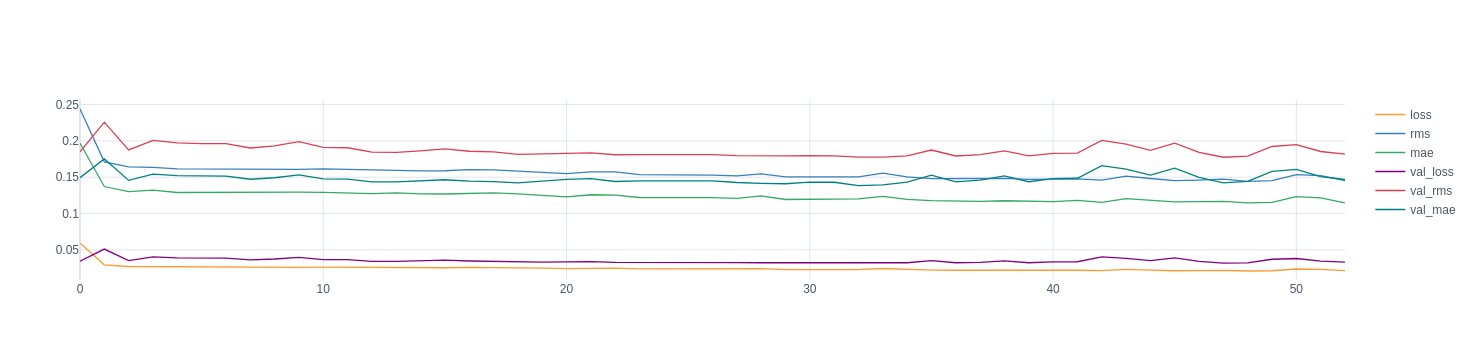

In [73]:
results.iplot()

### With bias

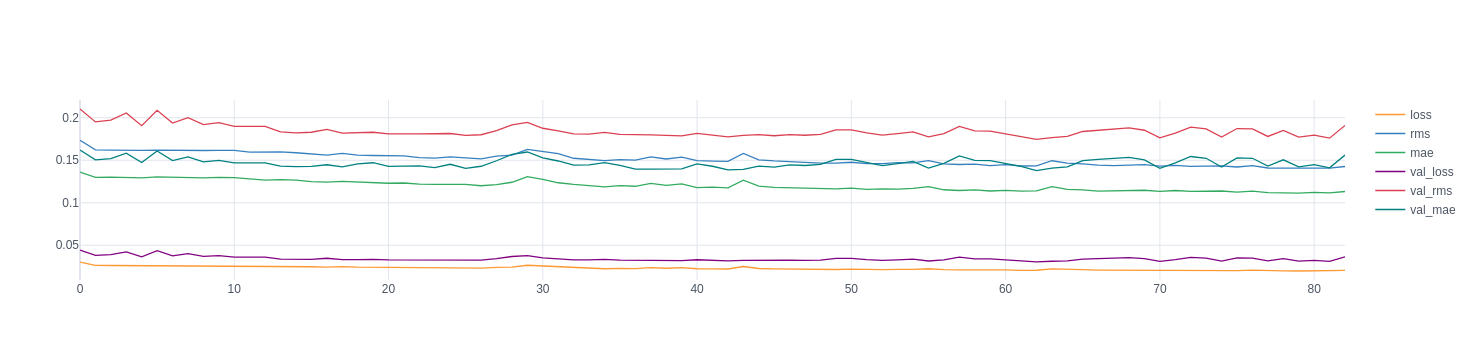

In [59]:
results.iplot()

In [74]:
df["y_hat_W"] = scy.inverse_transform(model.predict(scx.transform(Xi).reshape(len(Xi), 1, len(ls_cont))))

37/37 [==============================] - 0s 2ms/step


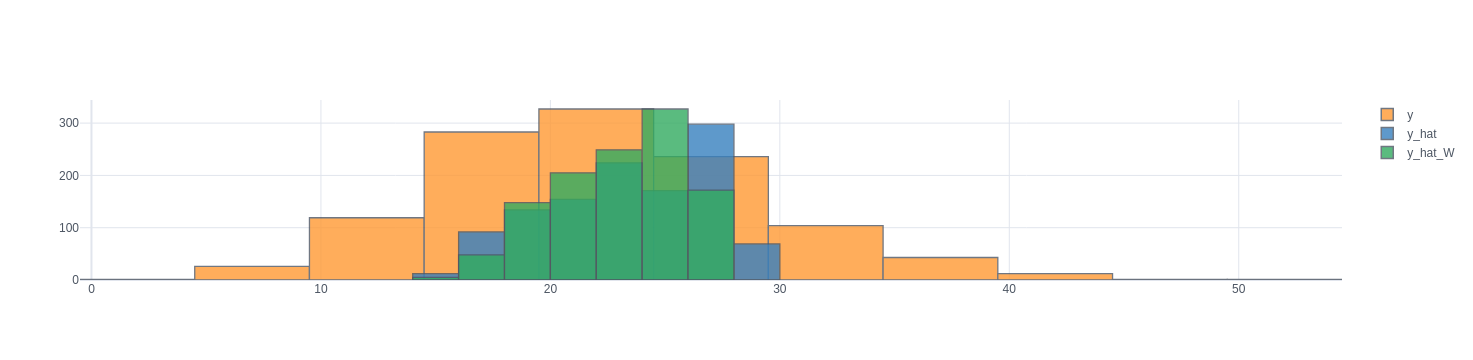

In [75]:
df[["y", "y_hat", "y_hat_W"]].iplot(kind="hist", bins=10)

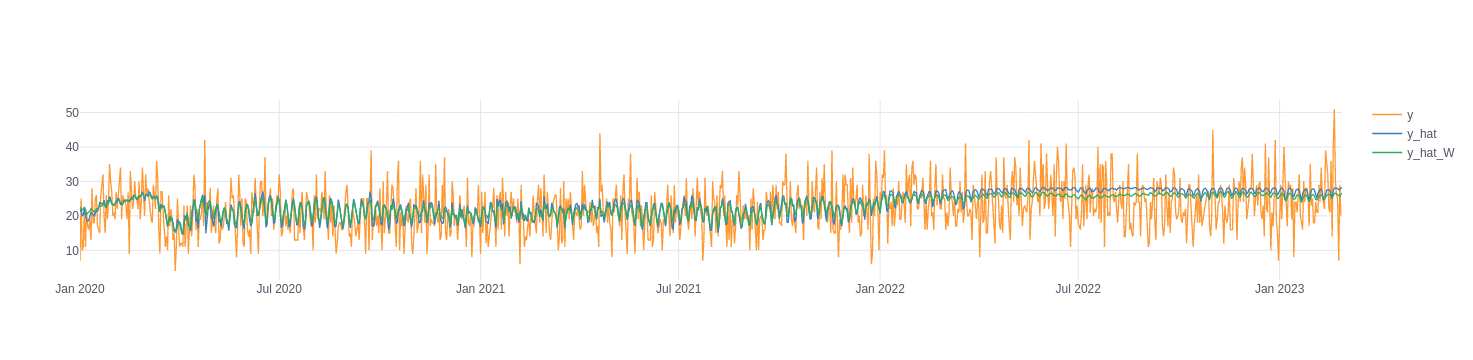

In [76]:
df[["y", "y_hat", "y_hat_W"]].iplot()

In [77]:
df.iloc[:,-3:]

,y,y_hat,y_hat_W
2020-01-01,7.0,21.351368,22.183542
2020-01-02,25.0,21.922132,22.354948
2020-01-03,10.0,20.027565,21.764946
2020-01-04,11.0,20.260983,21.883066
2020-01-05,22.0,22.012383,22.558270
...,...,...,...
2023-02-23,25.0,27.929781,26.040539
2023-02-24,7.0,27.583439,25.779968
2023-02-25,29.0,27.526527,25.647572
2023-02-26,20.0,28.064724,26.274206


In [97]:
mean_absolute_error(df.iloc[:-1,-3], df.iloc[:-1,-2])

5.001325122604966